# **TESLA Stock Market Prediction with LSTM**

### This project is aimed at predicting the stock price of Apple using historical data

- **Data Collection:** Gather historical stock market data from reliable sources, ensuring it includes essential features like date, open price, high price, low price, closing price, and volume. | `yfinance`
- **Data Preprocessing:** Clean the data by removing missing values and outliers, and normalize numerical features to a common scale to improve the LSTM model's convergence and performance.
- **Data Windowing:** Create data windows of size 5, where each window consists of 5 consecutive trading days as input features and the closing price of the 6th day as the target value.
- **Train-Test Split:** Split the data into training and testing sets, allocating around 80% for training and 20% for testing, while maintaining the temporal order of the data.
- **Reshape Data for LSTM:** Reshape the input data into a 3D array with dimensions (batch_size, time_steps, num_features) to match the expected input shape of the LSTM model, where time steps are 5 (window size) and num_features represent the input features.


## 1.Loading Data


[Apple](https://www.google.com/search?q=apple+share) We will download and predict `Apple` share.

https://www.google.com/search?q=apple+share

In [111]:
!pip install yfinance


In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

### 1. Getting the dataset

In [113]:
start_date = '2000-01-01'
end_date = '2024-08-01'

df = yf.download('aapl', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [114]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.844981,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.773741,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.785063,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.717125,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.751094,460734400
...,...,...,...,...,...,...
2024-07-25,218.929993,220.850006,214.619995,217.490005,217.490005,51391200
2024-07-26,218.699997,219.490005,216.009995,217.960007,217.960007,41601300
2024-07-29,216.960007,219.300003,215.750000,218.240005,218.240005,36311800


### 2. Data Understanding

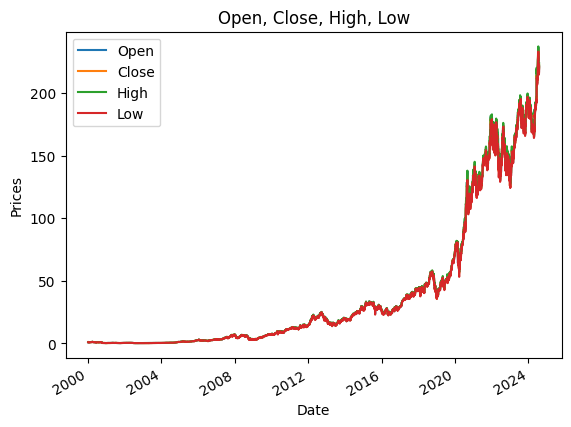

In [115]:
df[['Open','Close','High','Low']].plot()
plt.title('Open, Close, High, Low')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.show()

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6183 entries, 2000-01-03 to 2024-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6183 non-null   float64
 1   High       6183 non-null   float64
 2   Low        6183 non-null   float64
 3   Close      6183 non-null   float64
 4   Adj Close  6183 non-null   float64
 5   Volume     6183 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 338.1 KB


In [117]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6183.000000,6183.000000,6183.000000,6183.000000,6183.000000,6.183000e+03
mean,39.483225,39.906357,39.076604,39.507556,38.137896,3.917029e+08
std,55.659746,56.255911,55.102873,55.702538,55.482714,3.844161e+08
min,0.231964,0.235536,0.227143,0.234286,0.198078,2.404830e+07
25%,2.316071,2.344285,2.277321,2.305000,1.948768,1.215248e+08
50%,15.539286,15.674286,15.368214,15.473571,13.330140,2.737504e+08
75%,43.668749,43.883751,43.368750,43.709999,41.521852,5.255012e+08
max,236.479996,237.229996,233.089996,234.820007,234.820007,7.421641e+09


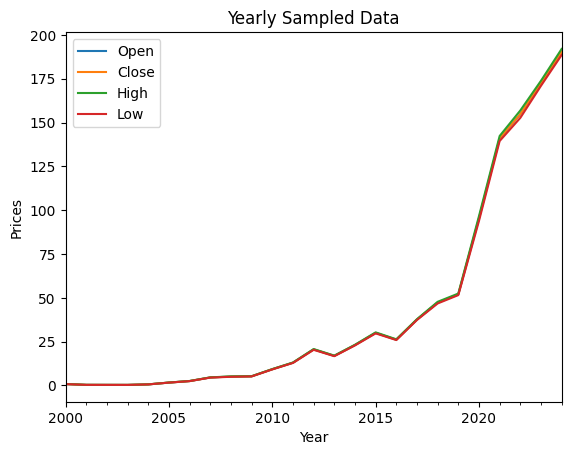

In [118]:
df[['Open','Close','High','Low']].resample('Y').mean().plot()
plt.title('Yearly Sampled Data')
plt.xlabel('Year')
plt.ylabel('Prices')
plt.show()

In [119]:
df.shape

(6183, 6)


### 3. Spliting Data as Train and Validation

In [120]:
data = df['Open'].tolist()

length_data = len(data)
split_ration = 0.7
length_train = round(length_data*split_ration)
length_data, length_train

(6183, 4328)

In [121]:
traindf=df.iloc[:length_train]
testdf=df.iloc[length_train:]

In [122]:
mv50= testdf['Close'].rolling(window=50).mean()
mv200= testdf['Close'].rolling(window=200).mean()

len(mv50[51:]), len(mv200)

(1804, 1855)

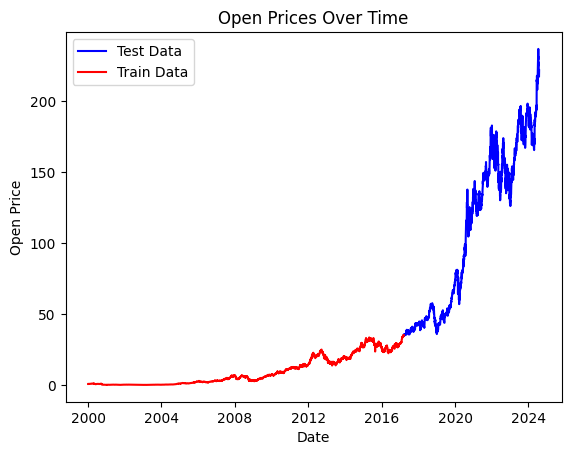

In [123]:
plt.plot(testdf.index, testdf['Open'], label='Test Data', color='blue')

plt.plot(traindf.index, traindf['Open'], label='Train Data', color='red')

# Adding legend
plt.legend()

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Open Prices Over Time')

# Show plot
plt.show()


In [124]:
train_data = data[:length_train]
test_data = data[length_train:]

### 4. Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [125]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data = np.array(train_data).reshape(-1, 1)
test_data = np.array(test_data).reshape(-1, 1)

In [126]:
train_data.shape, test_data.shape

((4328, 1), (1855, 1))

In [127]:
train_data_scaled = scaler.fit_transform(train_data).flatten()
test_data_scaled = scaler.fit_transform(test_data).flatten()

### 5. Dataset Windowing

In [128]:
train_data_scaled

array([0.02015621, 0.02101846, 0.01986878, ..., 0.98984207, 0.99062896,
       1.        ])

In [129]:
window_size=50

def windowed_dataset(data, window_size):
  X, y = [], []
  for i in range(len(data)-window_size-1):
    X.append(data[i:(i+window_size)])
    y.append(data[i+window_size])

  return np.array(X), np.array(y)

In [130]:
X_train, y_train = windowed_dataset(train_data_scaled, window_size)
X_test, y_test = windowed_dataset(test_data_scaled, window_size)

In [131]:
X_train

array([[0.02015621, 0.02101846, 0.01986878, ..., 0.0244515 , 0.02456327,
        0.02433172],
       [0.02101846, 0.01986878, 0.02047557, ..., 0.02456327, 0.02433172,
        0.02290263],
       [0.01986878, 0.02047557, 0.01801655, ..., 0.02433172, 0.02290263,
        0.02333376],
       ...,
       [0.83403928, 0.82638506, 0.82781579, ..., 0.98733831, 0.98583614,
        0.98948438],
       [0.82638506, 0.82781579, 0.82173535, ..., 0.98583614, 0.98948438,
        0.98662303],
       [0.82781579, 0.82173535, 0.82209299, ..., 0.98948438, 0.98662303,
        0.98984207]])

In [132]:
y_train

array([0.02290263, 0.02333376, 0.02405231, ..., 0.98662303, 0.98984207,
       0.99062896])

## 6. Creating LSTM model

In [136]:
model = Sequential()

# First LSTM layer with Batch Normalization
model.add(LSTM(units=window_size, activation='tanh', return_sequences=True,
               input_shape=(X_train.shape[1], 1), recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second LSTM layer with Batch Normalization
model.add(LSTM(units=window_size, activation='tanh', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Third LSTM layer with Batch Normalization
model.add(LSTM(units=window_size, activation='tanh', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Final LSTM layer
model.add(LSTM(units=window_size, activation='tanh'))

# Dense layers for added complexity
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model with Adam optimizer and a learning rate schedule
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,201 (289.85 KB)

 Trainable params: 73,901 (288.68 KB)

 Non-trainable params: 300 (1.17 KB)

In [137]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 50, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50)              │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,201 (289.85 KB)

 Trainable params: 73,901 (288.68 KB)

 Non-trainable params: 300 (1.17 KB)

In [140]:
# model.compile(loss=tf.keras.losses.Huber(), optimizer='sgd', metrics=['mae'])

In [141]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - loss: 0.0623
Epoch 2/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - loss: 0.0593
Epoch 3/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 0.0512
Epoch 4/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 0.0467
Epoch 5/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - loss: 0.0466
Epoch 6/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 0.0451
Epoch 7/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - loss: 0.0429
Epoch 8/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - loss: 0.0424
Epoch 9/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 0.0416
Epoch 10/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - loss: 0.0411
Epoch 11/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - loss: 0.0373
Epoch 12/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - loss: 0.0405
Epoch 13/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - loss: 0.0366
Epoch 14/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 0.0371
E

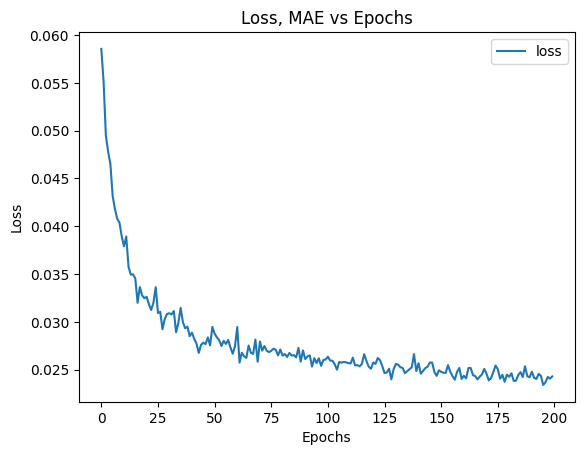

In [142]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss, MAE vs Epochs')
plt.show()

<a id="7"></a>
## 7.Evaluating Model

In [143]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


In [144]:
y_pred

array([[ 36.568413],
       [ 36.645477],
       [ 36.741238],
       ...,
       [214.76334 ],
       [213.90436 ],
       [213.15106 ]], dtype=float32)

In [145]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1))


In [146]:
display(len(y_test))
len(testdf)-50

testdf.iloc[51:].index

1804

DatetimeIndex(['2017-05-31', '2017-06-01', '2017-06-02', '2017-06-05',
               '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09',
               '2017-06-12', '2017-06-13',
               ...
               '2024-07-18', '2024-07-19', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-29',
               '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', name='Date', length=1804, freq=None)

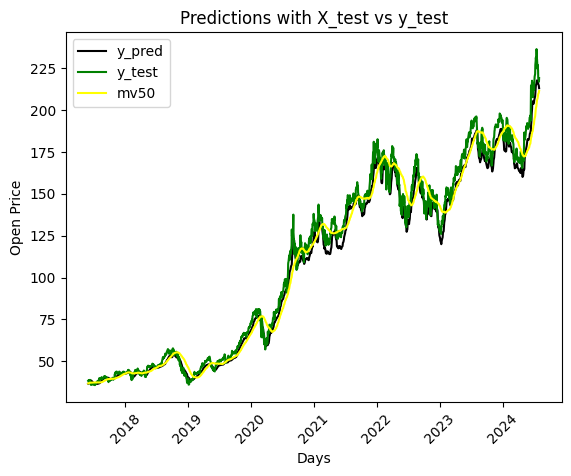

In [148]:
plt.plot(testdf.iloc[51:].index,y_pred, color='k', label='y_pred')
plt.plot(testdf.iloc[51:].index,y_test, color='g', label='y_test')
plt.plot(testdf.iloc[51:].index,mv50[51:], color='yellow', label='mv50')


len(mv50[51:]), len(mv200)
plt.xlabel('Days')
plt.ylabel('Open Price')
plt.title("Predictions with X_test vs y_test")
plt.xticks(rotation=45)
plt.legend()
plt.show()

###  8. Model Save and Load

In [152]:
import pickle
model.save('model.h5')
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [153]:
# from keras.models import load_model

# model1 = load_model('model.h5')
# scaler1 = pickle.load(open("scaler.pkl", "rb"))

In [154]:
def forecast(model, data, time_step, forecast_steps):
    forecasts = []
    input_seq = data[-time_step:].reshape(1, time_step, 1)
    for _ in range(forecast_steps):
        pred = model.predict(input_seq, verbose=0)
        forecasts.append(pred[0, 0])
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1, 0] = pred[0, 0]
    return np.array(forecasts)

In [157]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}


In [158]:
evaluate_model(testdf.iloc[51:]['Open'].values.flatten(),y_pred.flatten())

{'MSE': 45.13844716463991, 'RMSE': 6.71851525001171, 'MAE': 5.27165181991002}

In [159]:
evaluate_model(testdf.iloc[51:]['Open'].values.flatten(),mv50[51:])

{'MSE': 76.5385430959062, 'RMSE': 8.748630926945438, 'MAE': 6.60910254721631}

### The LSTM model over performed the moving average

In [160]:
def dm_test(y_true, y_pred1, y_pred2, h=1):
    e1 = y_true - y_pred1
    e2 = y_true - y_pred2
    d = e1 - e2
    acf_vals = acf(d, nlags=h, fft=False)
    dm_stat = np.mean(d) / np.sqrt(np.var(d)/len(d))
    p_value = 2 * norm.cdf(-abs(dm_stat))

    return dm_stat, p_value

dm_stat, p_value = dm_test(testdf.iloc[51:]['Open'].values.flatten(), y_pred.flatten(), mv50[51:])
print(f'Diebold-Mariano Test Statistic: {dm_stat}, p-value: {p_value}')


Diebold-Mariano Test Statistic: 14.491079704395597, p-value: 1.379570966186191e-47
